# MOwNiT – interpolacja funkcji sklejanej

__Przygotował:__
__Szymon Budziak__

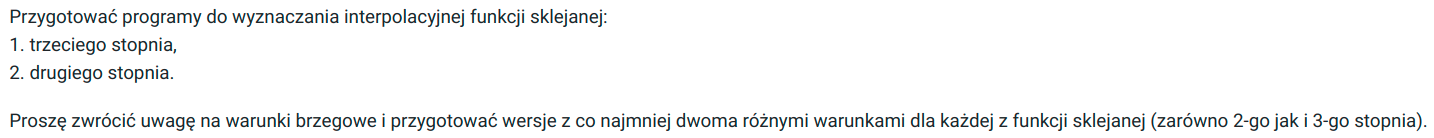

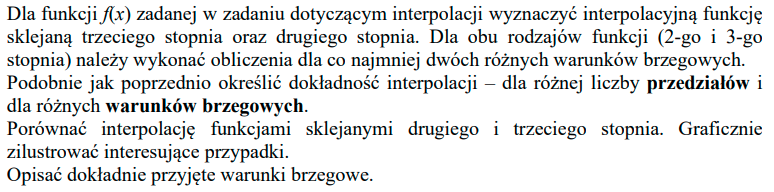

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

## Function to interpolate

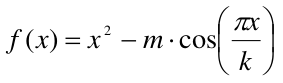

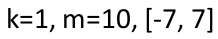

In [2]:
def func(x):
    k = 1
    m = 10
    y = x**2 - m*np.cos((np.pi*x) / k)
    return y

**Plot of the function**

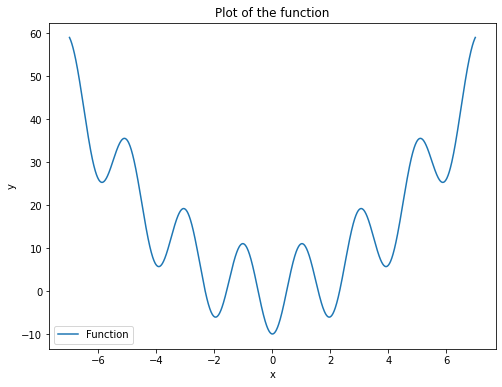

In [3]:
plt.figure(figsize=(8,6))
X = np.arange(-7, 7+0.01, 0.01)
plt.plot(X, func(X), label = "Function")
plt.title(f"Plot of the function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Visualization

In [4]:
def visualize(x, y, start, stop, n, function, name):
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, label="data", color="red")
    X = np.arange(start, stop+0.01, 0.01)
    plt.plot(X, func(X), label = "Function",color="red")
    if name == "own cubic spline":
        plt.plot(X, function(X), label = "Cubic spline", color="blue")
        plt.title(f"Own Cubic Spline implementation on {n} nodes")
    elif name == "scipy cubic spline":
        plt.plot(X, function(X), label = "Cubic spline", color="blue")
        plt.title(f"Scipy Cubic Spline on {n} nodes")
    elif name == "own quadratic spline":
        plt.plot(X, function(X), label = "Quadratic spline", color="blue")
        plt.title(f"Own Quadratic Spline on {n} nodes")
    elif name == "scipy quadratic spline":
        plt.plot(X, function(X), label = "Quadratic spline", color="blue")
        plt.title(f"Scipy Quadratic Spline on {n} nodes")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.savefig("fig.png")
    plt.show()

## Errors

In [5]:
def max_error(Y1, Y2):
    return max([abs(Y1[i] - Y2[i]) for i in range(len(Y1))])

In [6]:
def sum_square_error(Y1, Y2):
    return sum([(Y1[i] - Y2[i])**2 for i in range(len(Y1))])

## Cubic spline

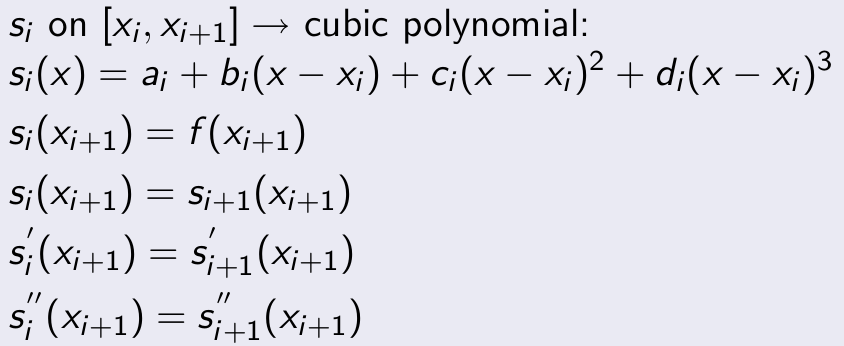

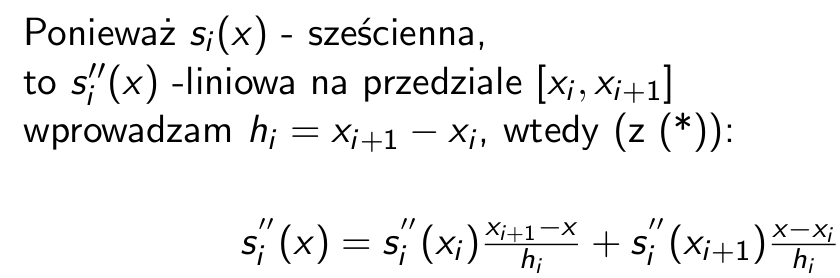

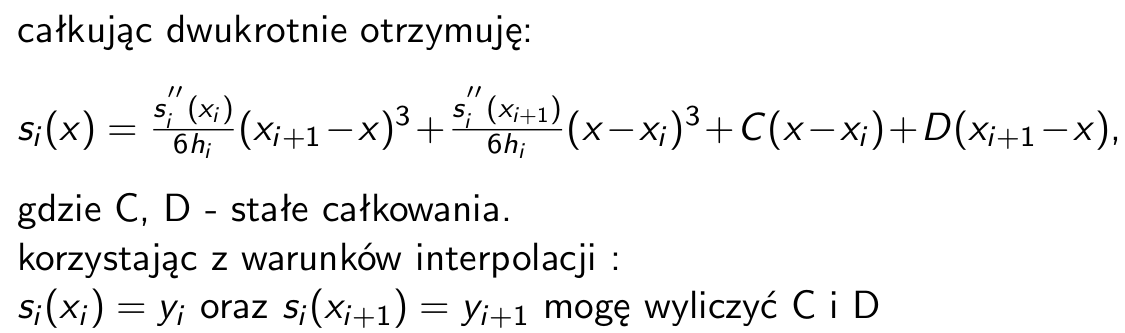

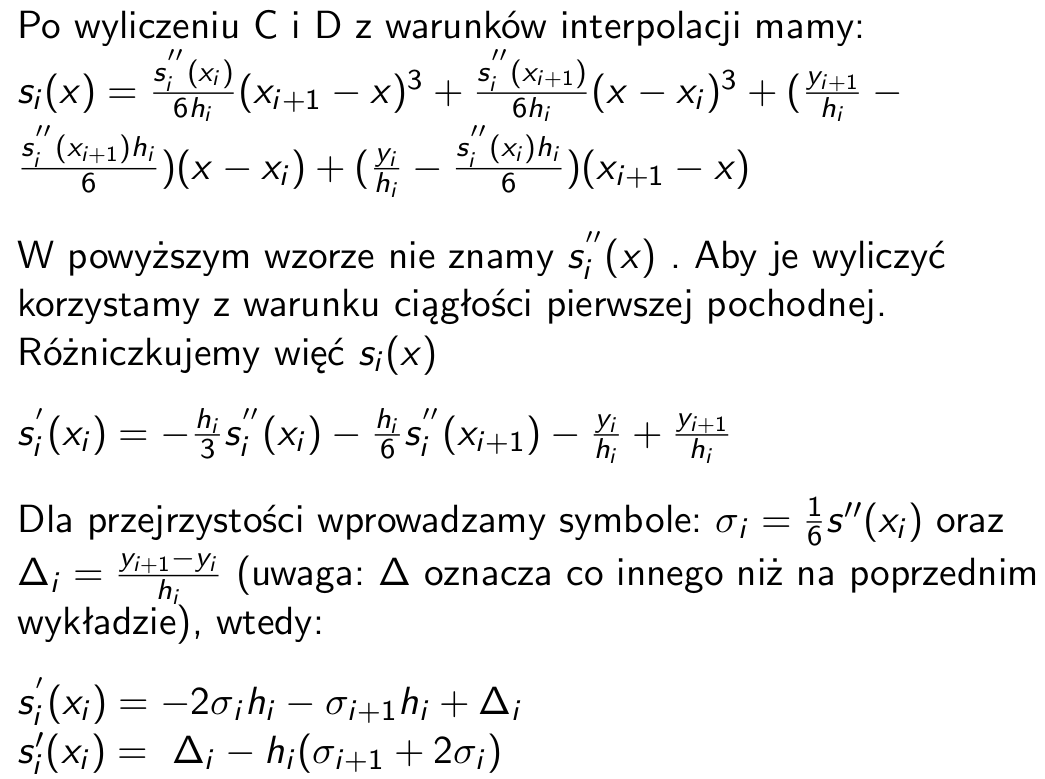

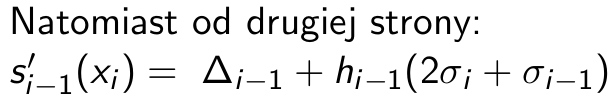

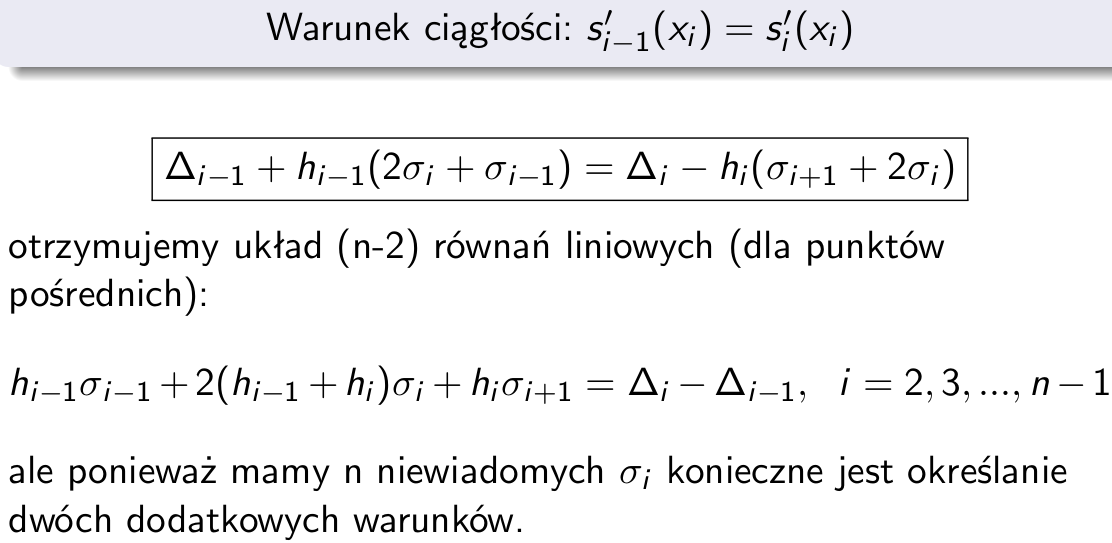

### SciPy interpolate.CubicSpline

In [7]:
def scipy_cubic_spline(start, stop, n, spline_type):
    X = np.linspace(start, stop, n)
    Y = func(X)
    cubic_spline = interpolate.CubicSpline(X, Y, bc_type=spline_type)
    visualize(X, Y, start, stop, n, cubic_spline, "scipy cubic spline")

#### natural spline

n = 5

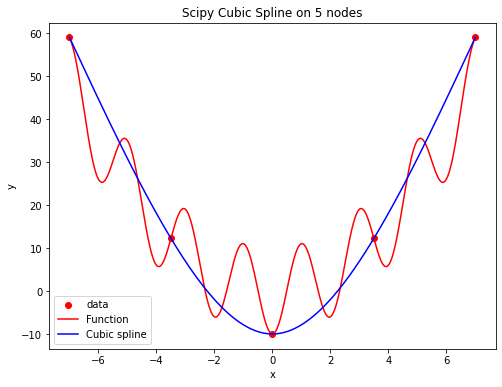

In [8]:
scipy_cubic_spline(-7, 7, 5, "natural")

n = 15

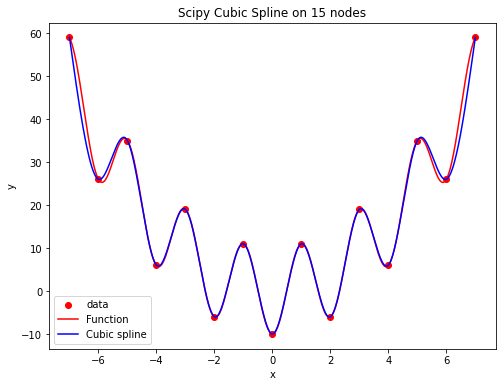

In [9]:
scipy_cubic_spline(-7, 7, 15, "natural")

n = 30

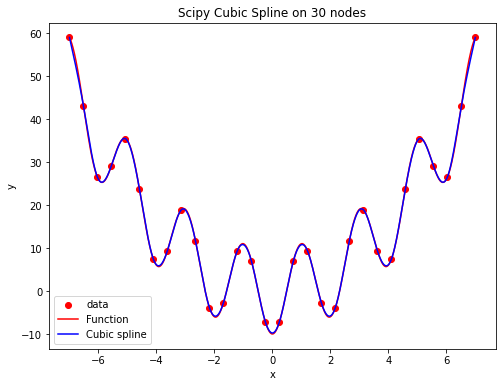

In [10]:
scipy_cubic_spline(-7, 7, 30, "natural")

__clamped spline__

n = 8

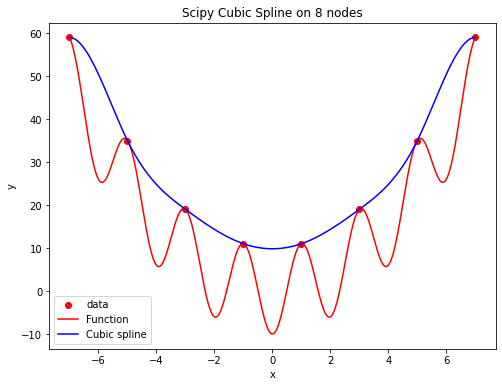

In [11]:
scipy_cubic_spline(-7, 7, 8, "clamped")

n = 20

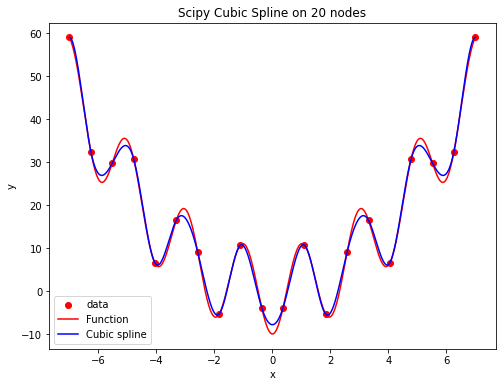

In [12]:
scipy_cubic_spline(-7, 7, 20, "clamped")

n = 50

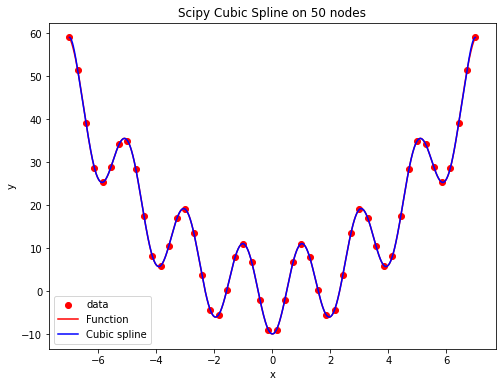

In [13]:
scipy_cubic_spline(-7, 7, 50, "clamped")

### Own implementation

In [14]:
class CubicSpline:
    def __init__(self, X, Y, spline_type):
        self.X = X
        self.Y = Y
        self.n = len(X)
        self.sigma = None
        self.solve(spline_type)

    def h(self, i):
        return self.X[i + 1] - self.X[i]

    def delta(self, i):
        return (self.Y[i + 1] - self.Y[i]) / self.h(i)

    def delta2(self, i):
        return (self.delta(i + 1) - self.delta(i)) / (self.X[i + 1] - self.X[i - 1])

    def delta3(self, i):
        return (self.delta2(i + 1) - self.delta2(i)) / (self.X[i + 2] - self.X[i - 1])

    def fill_boundaries(self, h_matrix, d_matrix, spline_type):
        if spline_type == "cubic":
            h_matrix[0][0] = -self.h(0)
            h_matrix[0][1] = self.h(0)
            h_matrix[self.n - 1][self.n - 2] = self.h(self.n - 2)
            h_matrix[self.n - 1][self.n - 1] = -self.h(self.n - 2)

            d_matrix[0] = np.power(self.h(0), 2) * self.delta3(0)
            d_matrix[self.n - 1] = -np.power(self.h(self.n - 2), 2) * self.delta3(self.n - 4)
            self.sigma = np.linalg.solve(h_matrix, d_matrix)
        elif spline_type == "natural":
            h_matrix = h_matrix[1:-1, 1:-1]
            d_matrix = d_matrix[1:-1]
            self.sigma = [0, *np.linalg.solve(h_matrix, d_matrix), 0]

    def solve(self, spline_type):
        h_matrix = np.zeros(shape=(self.n, self.n))
        d_matrix = np.zeros(shape=(self.n, 1))
        for i in range(1, self.n - 1):
            h_matrix[i][i - 1] = self.h(i - 1)
            h_matrix[i][i] = 2 * (self.h(i - 1) + self.h(i))
            h_matrix[i][i + 1] = self.h(i)

            d_matrix[i] = self.delta(i) - self.delta(i - 1)

        self.fill_boundaries(h_matrix, d_matrix, spline_type)

    def find_interval(self, x):
        l = 0
        r = self.n - 1
        while l <= r:
            mid = (l + r) // 2
            if x >= self.X[mid]:
                l = mid + 1
            else:
                r = mid - 1
        return l - 1

    def s(self, x):
        i = min(self.find_interval(x), self.n - 2)
        b = (self.Y[i + 1] - self.Y[i]) / self.h(i) - self.h(i) * (self.sigma[i + 1] + 2 * self.sigma[i])
        c = 3 * self.sigma[i]
        d = (self.sigma[i + 1] - self.sigma[i]) / self.h(i)
        return self.Y[i] + b * (x - self.X[i]) + c * np.power(x - self.X[i], 2) + d * np.power(x - self.X[i], 3)

    def S(self, xs):
        return [self.s(x) for x in xs]

In [15]:
def own_cubic_spline(start, stop, n, spline_type):
    X = np.linspace(start, stop, n)
    Y = func(X)
    cubic_spline = CubicSpline(X, Y, spline_type)
    visualize(X, Y, start, stop, n, cubic_spline.S, "own cubic spline")

#### natural spline

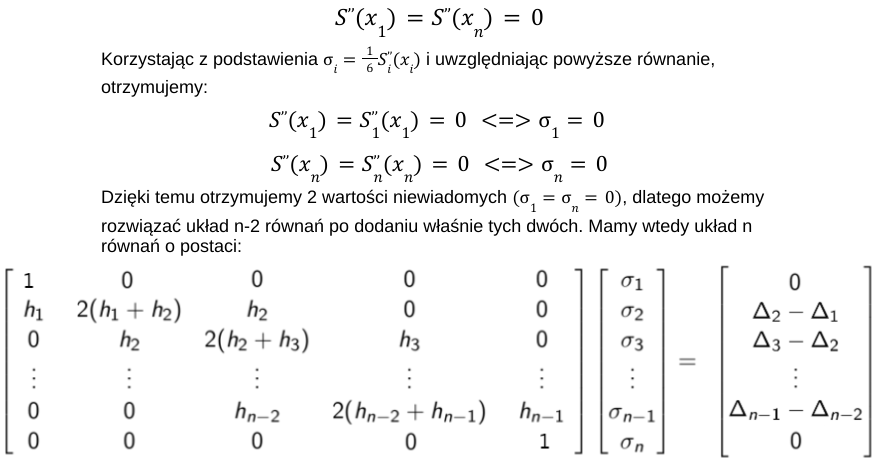

n = 5

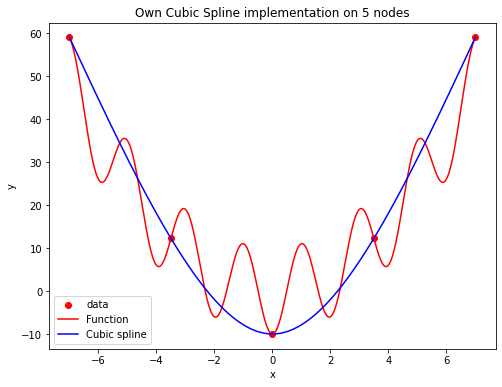

In [16]:
own_cubic_spline(-7, 7, 5, "natural")

n = 15

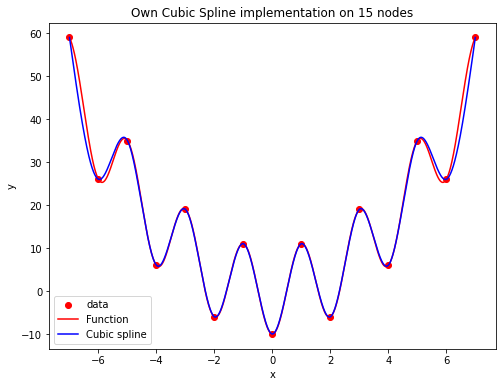

In [17]:
own_cubic_spline(-7, 7, 15, "natural")

n = 30

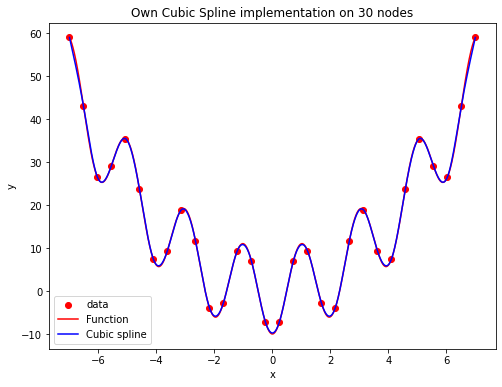

In [18]:
own_cubic_spline(-7, 7, 30, "natural")

#### cupic spline

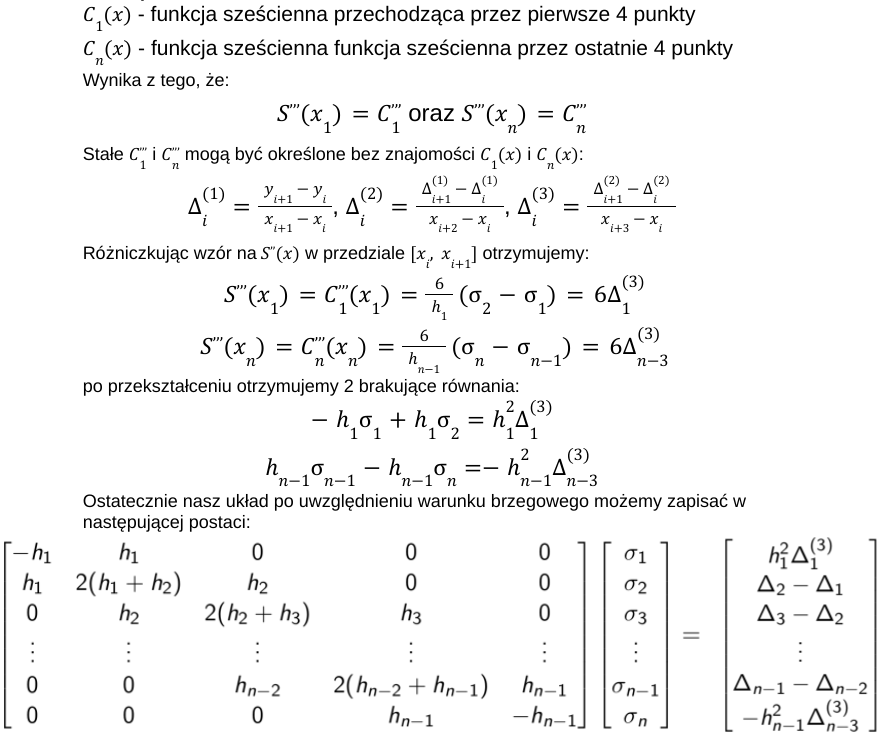

n = 7

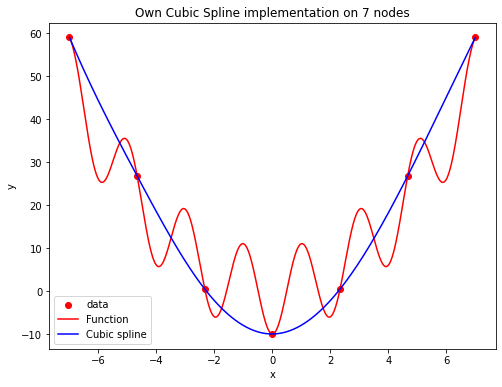

In [19]:
own_cubic_spline(-7, 7, 7, "cubic")

n = 18

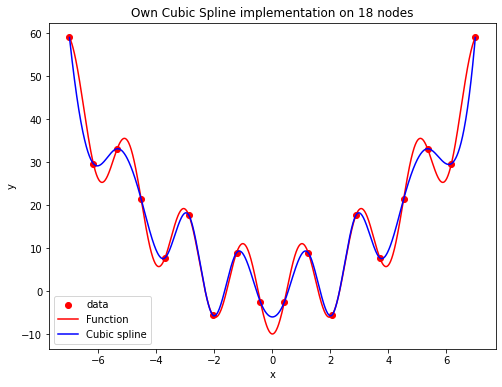

In [20]:
own_cubic_spline(-7, 7, 18, "cubic")

n = 40

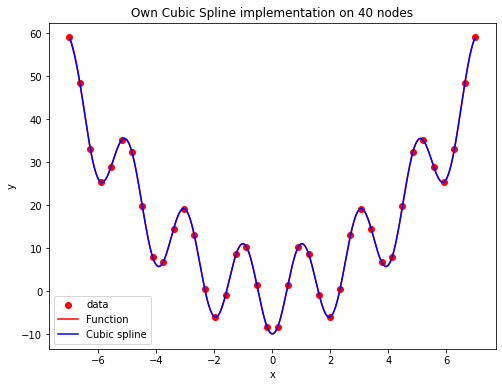

In [21]:
own_cubic_spline(-7, 7, 40, "cubic")

## Quadratic spline

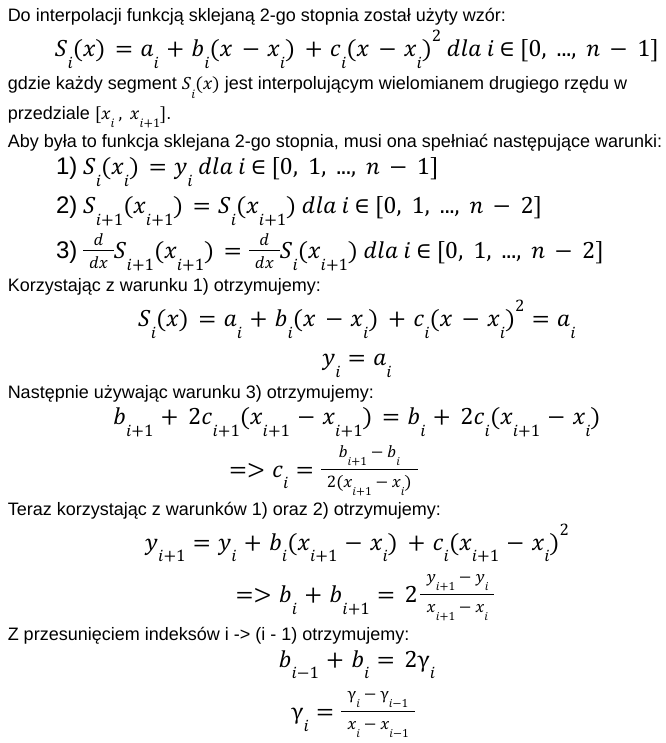

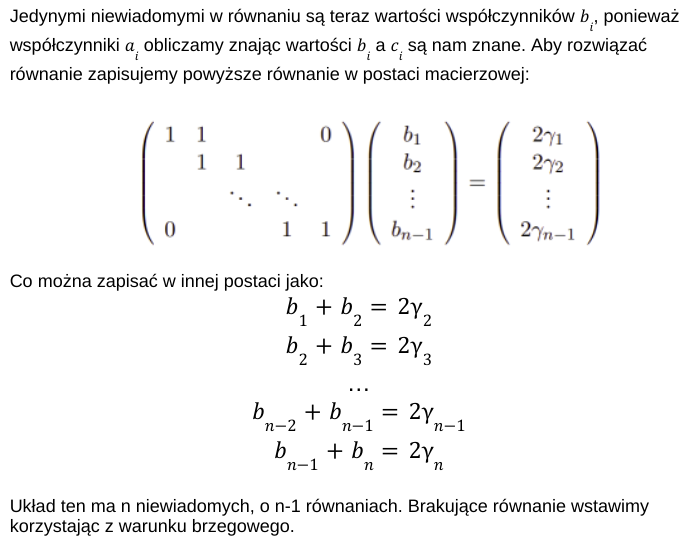

### SciPy interpolate.interp1d(kind="quadratic")

In [22]:
def scipy_quadratic_spline(start, stop, n):
    X = np.linspace(start, stop, n)
    Y = func(X)
    quadratic_spline = interpolate.interp1d(X, Y, kind="quadratic")
    visualize(X, Y, start, stop, n, quadratic_spline, "scipy quadratic spline")

n = 6

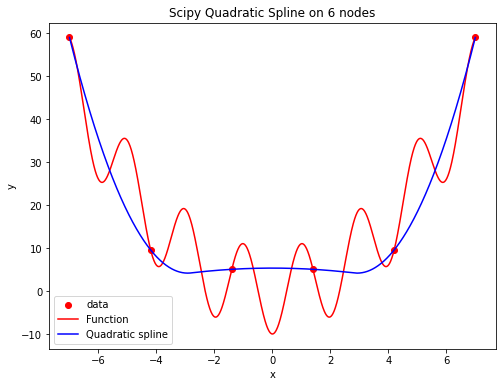

In [23]:
scipy_quadratic_spline(-7, 7, 6)

n = 17

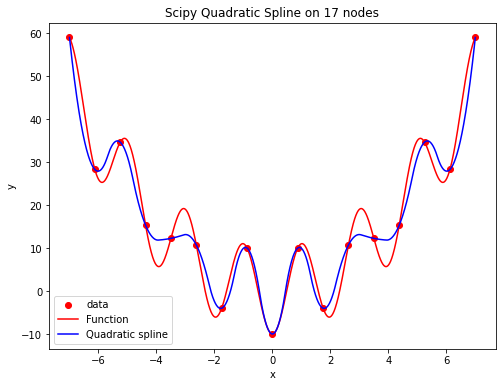

In [24]:
scipy_quadratic_spline(-7, 7, 17)

n = 35

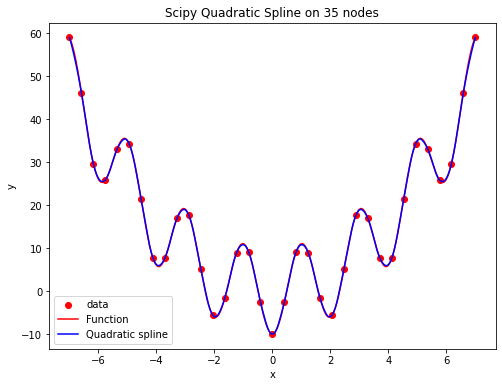

In [25]:
scipy_quadratic_spline(-7, 7, 35)

### Own implementation

In [26]:
class QuadraticSpline:
    def __init__(self, X, Y, spline_type):
        self.X = X
        self.Y = Y
        self.n = len(X)
        self.a = None
        self.b = None
        self.solve(spline_type)

    def gamma(self, i):
        return (self.Y[i] - self.Y[i - 1]) / (self.X[i] - self.X[i - 1])

    # natural spline
    def a_natural(self, i):
        return (self.b_natural(i + 1) - self.b_natural(i)) / (2 * (self.X[i + 1] - self.X[i]))

    def b_natural(self, i):
        if i == 0:
            return 0
        return 2 * self.gamma(i) - self.b_natural(i - 1)

    # clamped spline
    def a_clamped(self, i):
        return (self.b_clamped(i + 1) - self.b_clamped(i)) / (2 * (self.X[i + 1] - self.X[i]))

    def b_clamped(self, i):
        if i == 0:
            return (self.Y[1] - self.Y[0]) / np.power((self.X[1] - self.X[0]), 2)
        return 2 * self.gamma(i) - self.b_clamped(i - 1)

    def solve(self, spline_type):
        if spline_type == "clamped":
            self.a = self.a_clamped
            self.b = self.b_clamped
        elif spline_type == "natural":
            self.a = self.a_natural
            self.b = self.b_natural

    def find_interval(self, x):
        l = 0
        r = self.n - 1
        while l <= r:
            mid = (l + r) // 2
            if x >= self.X[mid]:
                l = mid + 1
            else:
                r = mid - 1
        return l - 1

    def s(self, x):
        i = min(self.find_interval(x), self.n - 2)
        a = self.a(i)
        b = self.b(i)
        return a * np.power(x - self.X[i], 2) + b * (x - self.X[i]) + self.Y[i]

    def S(self, xs):
        return [self.s(x) for x in xs]

In [27]:
def own_quadratic_spline(start, stop, n, spline_type):
    X = np.linspace(start, stop, n)
    Y = func(X)
    quadratic_spline = QuadraticSpline(X, Y, spline_type)
    visualize(X, Y, start, stop, n, quadratic_spline.S, "own quadratic spline")

__natural spline__

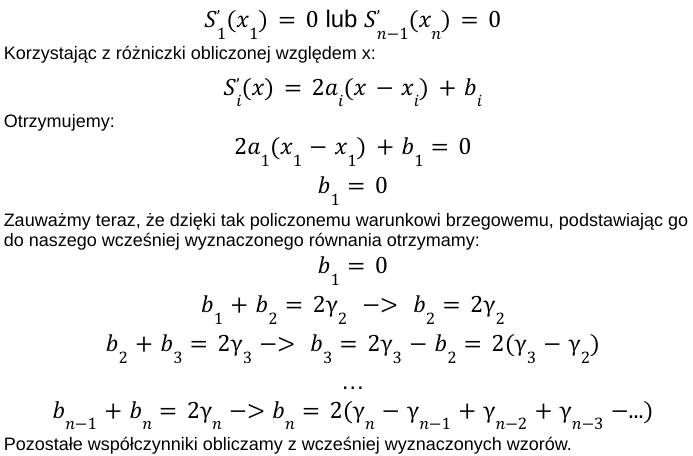

n = 4

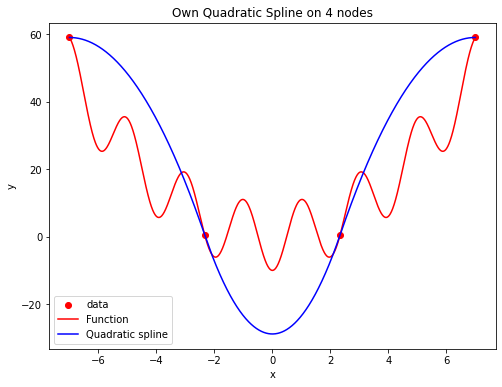

In [28]:
own_quadratic_spline(-7, 7, 4, "natural")

n = 20

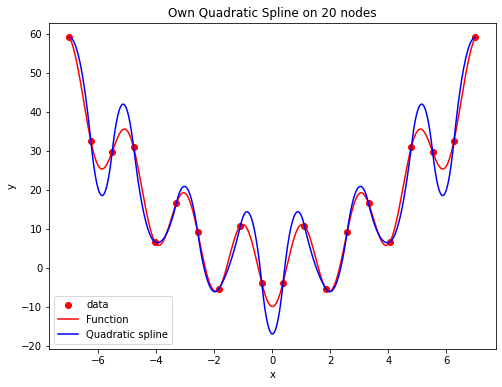

In [29]:
own_quadratic_spline(-7, 7, 20, "natural")

n = 35

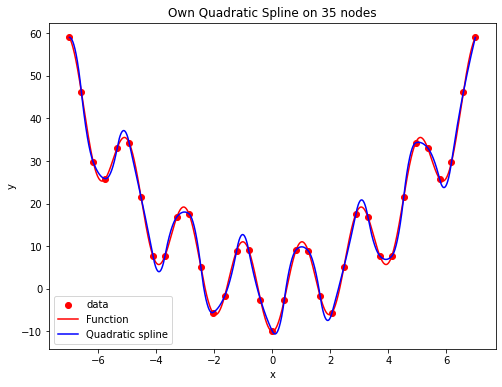

In [30]:
own_quadratic_spline(-7, 7, 35, "natural")

__clamped spline__

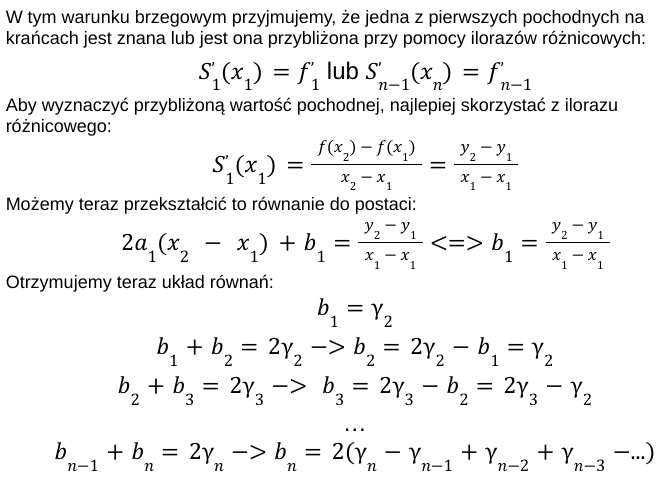

n = 5

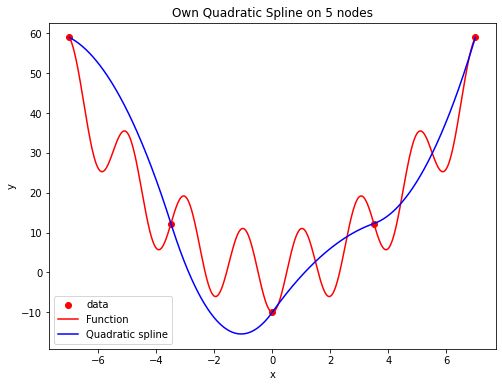

In [31]:
own_quadratic_spline(-7, 7, 5, "clamped")

n = 14

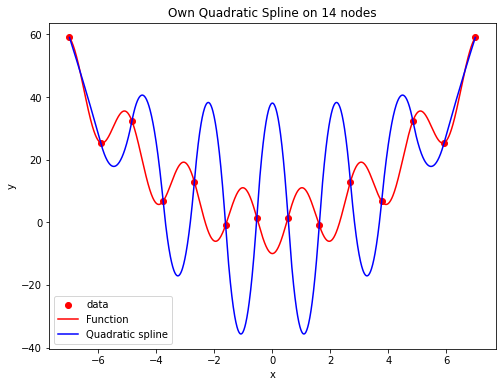

In [40]:
own_quadratic_spline(-7, 7, 14, "clamped")

n = 40

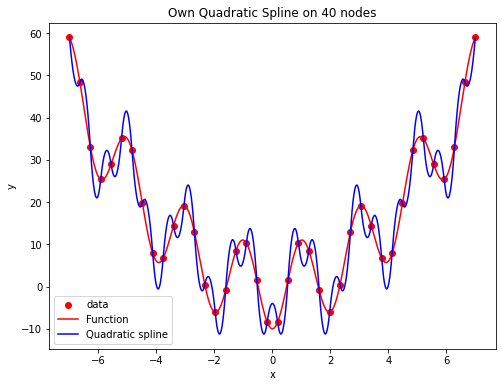

In [33]:
own_quadratic_spline(-7, 7, 40 , "clamped")

In [34]:
def calculate_error(start, stop):
    nodes = [4, 5, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100, 150, 200, 500]
    result = [None for _ in range(8*len(nodes))]

    df_result = pd.DataFrame()
    total_X = np.linspace(start, stop, 1000)
    func_val = func(total_X)
    idx = 0
    for n in nodes:
        X = np.linspace(start, stop, n)
        Y = func(X)
        nat_cubic_spline = CubicSpline(X, Y, "natural")
        nat_cubic_result = [item for sublist in nat_cubic_spline.S(total_X) for item in sublist]
        result[idx] = max_error(nat_cubic_result, func_val)
        result[idx + 1] = sum_square_error(nat_cubic_result, func_val)
        
        cub_cubic_spline = CubicSpline(X, Y, "cubic")
        cub_cubic_result = [item for sublist in cub_cubic_spline.S(total_X) for item in sublist]
        result[idx + 2] = max_error(cub_cubic_result, func_val)
        result[idx + 3] = sum_square_error(cub_cubic_result, func_val)
        
        nat_quadr_spline = QuadraticSpline(X, Y, "natural")
        result[idx + 4] = max_error(nat_quadr_spline.S(total_X), func_val)
        result[idx + 5] = sum_square_error(nat_quadr_spline.S(total_X), func_val)
        
        cla_quadr_spline = QuadraticSpline(X, Y, "clamped")
        result[idx + 6] = max_error(cla_quadr_spline.S(total_X), func_val)
        result[idx + 7] = sum_square_error(cla_quadr_spline.S(total_X), func_val)
        idx += 8
    df = pd.DataFrame(data={"n": nodes,
                              "cubic natural max error": result[::8],
                              "cubic natural sum square error": result[1::8],
                              "cubic cubic max error": result[2::8],
                              "cubic cubic sum square error": result[3::8],
                              "quadratic natural max error": result[4::8],
                              "quadratic natural sum square error": result[5::8],
                              "quadratic clamped max error": result[6::8],
                              "quadratic clamped sum square error": result[7::8]})
    df.to_excel("out.xlsx")
    return df

## Error for Cubic and Quadratic interpolation

In [35]:
df = calculate_error(-7, 7)
df

,n,cubic natural max error,cubic natural sum square error,cubic cubic max error,cubic cubic sum square error,quadratic natural max error,quadratic natural sum square error,quadratic clamped max error,quadratic clamped sum square error
0,4,18.093140,88770.625358,25.740216,1.212786e+05,34.814283,4.193309e+05,32.167164,3.387414e+05
1,5,18.890802,96977.257531,19.185013,8.762792e+04,29.271204,1.834839e+05,26.492499,1.458353e+05
2,7,18.996067,99423.119143,19.151467,9.846392e+04,27.081734,1.356969e+05,23.701777,1.120034e+05
3,8,20.366009,151305.911681,20.061867,1.494024e+05,26.999492,1.933260e+05,23.999519,1.682998e+05
4,9,19.015553,99735.566533,19.092181,9.960031e+04,25.109292,1.203474e+05,21.669592,1.040840e+05
5,10,19.833561,95664.415309,19.836811,9.672842e+04,25.798620,1.357711e+05,21.359803,1.076611e+05
6,15,5.949000,2564.949549,12.541351,8.837685e+03,138.558417,3.746393e+06,130.311401,3.136503e+06
7,20,4.421448,2446.906235,6.437996,3.533122e+03,7.032380,1.093058e+04,10.825155,2.366966e+04
8,25,2.412848,360.563243,2.552372,3.203096e+02,3.289848,2.725981e+03,7.954568,2.447559e+04
9,30,1.477877,92.660942,1.239793,4.329201e+01,2.204357,1.662321e+03,7.099064,2.304004e+04


In [36]:
print(df["cubic natural max error"].idxmin())
print(df["cubic natural sum square error"].idxmin())
print(df["cubic cubic max error"].idxmin())
print(df["cubic cubic sum square error"].idxmin())
print(df["quadratic natural max error"].idxmin())
print(df["quadratic natural sum square error"].idxmin())
print(df["quadratic clamped max error"].idxmin())
print(df["quadratic clamped sum square error"].idxmin())

18
18
18
18
18
18
18
18


Dzięki `max erro`r oraz `sum square error` możemy znaleźć najlepszy wielomian (jego stopień) który interpoluje naszą funkcję. Rozpatrzyliśmy to dla interpolacji `3-go` oraz `2-go stopnia` i dla warunków brzegowych `natural`, `cubic` i `clamped`. W naszym przypadku jest to wielomian stopnia `n = 500`. Możemy zauważyć, że błąd zmniejsza się wraz z coraz wiekszą liczbą punktów interpolacji. Możemy wysunąc więc wniosek, że nie występuje efekt Rungego w przypadku funkcji sklejanych.

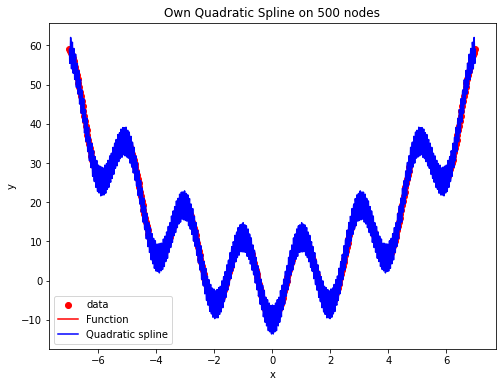

In [37]:
own_quadratic_spline(-7, 7, 500, "clamped")

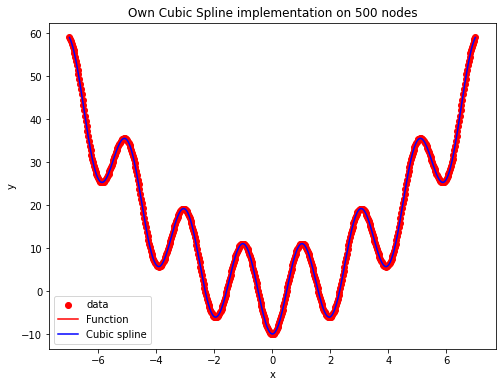

In [38]:
own_cubic_spline(-7, 7, 500, "cubic")